In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from sklearn.utils import shuffle
import numpy as np
import os
import cv2
import tensorflow.keras.backend as K

In [2]:
DATADIR = "data/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 70
training_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,class_num])



In [11]:
DATADIR = "data/Testing/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 70
testing_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        testing_data.append([new_array,class_num])


In [12]:
test_X = []
test_y = []

for image, label in testing_data:
    test_X.append(image)
    test_y.append(label)

test_X = np.array(test_X).reshape(-1,IMG_SIZE,IMG_SIZE)
test_X = test_X/128.0 - 1  
test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = np.array(test_y)

test_X, test_y = shuffle(test_X, test_y)

In [3]:
train_X = []
train_y = []

for image, label in training_data:
    train_X.append(image)
    train_y.append(label)

train_X = np.array(train_X).reshape(-1,IMG_SIZE,IMG_SIZE)
train_X = train_X/128.0 - 1  
train_X = train_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
train_y = np.array(train_y)

train_X, train_y = shuffle(train_X, train_y)

In [4]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(70, 70, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation = "softmax"))

model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=[get_f1, 'accuracy'])

history = model.fit(train_X, train_y, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
72/72 [==============================] - 4s 53ms/step - loss: 1.0037 - get_f1: 1.9236 - accuracy: 0.5531 - val_loss: 0.7819 - val_get_f1: 1.1203 - val_accuracy: 0.6672
Epoch 2/10
72/72 [==============================] - 4s 51ms/step - loss: 0.6546 - get_f1: 1.0482 - accuracy: 0.7234 - val_loss: 0.6547 - val_get_f1: 1.0875 - val_accuracy: 0.7143
Epoch 3/10
72/72 [==============================] - 4s 52ms/step - loss: 0.5380 - get_f1: 0.9819 - accuracy: 0.7753 - val_loss: 0.5399 - val_get_f1: 0.9147 - val_accuracy: 0.7700
Epoch 4/10
72/72 [==============================] - 4s 51ms/step - loss: 0.4659 - get_f1: 0.9389 - accuracy: 0.8197 - val_loss: 0.5026 - val_get_f1: 0.9343 - val_accuracy: 0.8118
Epoch 5/10
72/72 [==============================] - 4s 51ms/step - loss: 0.3781 - get_f1: 0.9099 - accuracy: 0.8476 - val_loss: 0.4365 - val_get_f1: 0.9016 - val_accuracy: 0.8397
Epoch 6/10
72/72 [==============================] - 4s 52ms/step - loss: 0.3040 - get_f1: 0.8975 - accura

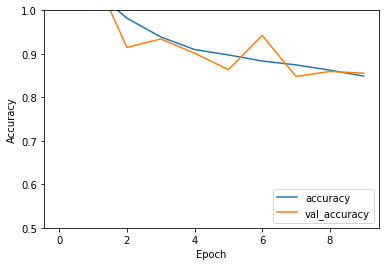

In [9]:
plt.plot(history.history['get_f1'], label='accuracy')
plt.plot(history.history['val_get_f1'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [18]:
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred,axis=1)

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

clf_report = classification_report(test_y,y_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.90      0.18      0.30       100
           1       0.64      0.94      0.76       115
           2       0.67      0.96      0.79       105
           3       0.85      0.62      0.72        74

    accuracy                           0.69       394
   macro avg       0.76      0.68      0.64       394
weighted avg       0.75      0.69      0.64       394



In [ ]:
# plt.style.use("ggplot")
# plt.figure(figsize=(12,6))
# epochs = range(1,16)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history["accuracy"],'go-')
# plt.plot(epochs,history.history["val_accuracy"],'ro-')
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(['Train','Val'],loc = "upper left")

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history["loss"],'go-')
# plt.plot(epochs,history.history["val_loss"],'ro-')
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(['Train','Val'],loc = "upper left")

# plt.show()